<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/tapi-logo-small.png" />

This notebook free for educational reuse under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/).

Created by [Firstname Lastname](https://) for the 2024 Text Analysis Pedagogy Institute, with support from [Constellate](https://constellate.org).

For questions/comments/improvements, email author@email.address.<br />
____

# `Introduction to Semantic Search and Vector Databases` `1`

This is lesson `1` of 3 in the educational series on `Semantic Search and Vector Databases`. This notebook is intended `to teach the basic concepts of vector databases`.

**Skills:** 
* Data analysis
* Machine learning
* Text analysis
* spaCy
* Vector databases
* Semantic search
* Python

**Audience:** `Teachers` / `Learners` / `Researchers`

**Use case:** `Tutorial` / `How-To` / `Explanation` 

`Include the use case definition from [here](https://constellate.org/docs/documentation-categories)`

**Difficulty:** `Intermediate`

`Beginner assumes users are relatively new to Python and Jupyter Notebooks. The user is helped step-by-step with lots of explanatory text.`
`Intermediate assumes users are familiar with Python and have been programming for 6+ months. Code makes up a larger part of the notebook and basic concepts related to Python are not explained.`
`Advanced assumes users are very familiar with Python and have been programming for years, but they may not be familiar with the process being explained.`

**Completion time:** `90 minutes`

**Knowledge Required:** 
```
* Python basics (variables, flow control, functions, lists, dictionaries)
* Object-oriented programming (classes, instances, inheritance)
* Regular Expressions (`re`, character classes)

These should be general skills but can mention a particular library
```

**Knowledge Recommended:**
```
* Basic file operations (open, close, read, write)
* Data cleaning with `Pandas`
```

**Learning Objectives:**
After this lesson, learners will be able to:
```
1. Describe and implement an XXXX for XXXX
2. Convert XXXX into XXXX for the purpose of XXXX
3. Develop a workflow in order to XXXX
4. Be familiar with XXXXX resources for pursuing the topic
```
**Research Pipeline:**
```
1. Research steps before this notebook
2. **The skills in this notebook**
3. Steps after this notebook
4. Final steps
```
___

# Required Python Libraries
`List out any libraries used and what they are used for`
* [Tesseract](https://tesseract-ocr.github.io/) for performing [optical character recognition](https://docs.constellate.org/key-terms/#ocr).
* [Pandas](https://pandas.pydata.org/) for manipulating and cleaning data.
* [Pdf2image](https://pdf2image.readthedocs.io/en/latest/) for converting pdf files into image files.

## Install Required Libraries

In [43]:
### Install Libraries ###

# Using !pip installs
!pip install txtai spacy tqdm pandas annoy sentence-transformers pillow weaviate-client

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached Authlib-1.3.1-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached protobuf-5.27.2-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.3/368.3 kB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.4 MB/s eta 0:00:00
Using cached Authlib-1.3.1-py2.py3-none-any.whl (223 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 60.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 36.2 MB/s eta 0:00:00a 0:00:01
Using cached protobuf-5.27.2-cp38-abi3-macosx_10_9_universal2.whl (412 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 62.8 MB/s eta 0:00:00a 0:00:01


In [1]:
# https://github.com/neuml/txtai/issues/685
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
### Import Libraries ###
from txtai.embeddings import Embeddings
import srsly
import pandas as pd
from tqdm import tqdm
import spacy

from sentence_transformers import SentenceTransformer
import glob
from PIL import Image
from annoy import AnnoyIndex

# Introduction

In this notebook, we will build on our previous knowledge from the last notebook. We will learn how to create vector databases again, but this time with a different framework: `txtai`. The big advantage of `txtai` is that it handles a lot of the complex issues for you automatically. It also comes with a suite of extra tools for handling more complex tasks. Want to know `why` certain results are returned the way they are? Txtai can handle that. Want to use your vector database to create a retrieval augmented generation (RAG) system? Txtai can handle that.

While we worked solely with texts in the last notebook, in this notebook we will also learn about an important concept in both vector databases and semantic searching: multimodality. This allows us to create vector databases that store not only text, but also images or other forms of data. We will learn how we create multimodal vector databases and, most importantly, how to query them. In this notebook, we will create a vector databases of images and query them with raw text.

Finally, I'd like for you to leave this course with a basic understanding of the next steps. What do you do with this knowledge? How do you build systems that can function not only at scale, but in the cloud? We will answer these questions as we explore Weaviate, a cloud-based open-source vector database solution.

# Loading our Data

As we did in the last notebook, we will begin with the same data: small sample from Founders Online. This is a random collection of 1,000 texts from the archive. Let's go ahead and load it up, just as we did before.

In [3]:
data = list(srsly.read_json("../data/processed/sample_1000_42.json"))

Now that we have our data loaded, let's go ahead and examine it. Let's take a look at the first index.

In [21]:
data[0]

{'title': 'Thomas Jefferson to Joseph Milligan, 22 December 1815',
 'permalink': 'https://founders.archives.gov/documents/Jefferson/03-09-02-0174',
 'project': 'Jefferson Papers',
 'authors': ['Jefferson, Thomas'],
 'recipients': ['Milligan, Joseph'],
 'date-from': '1815-12-22',
 'date-to': '1815-12-22',
 'content': 'Monticello Dec. 22. 15.\nDear Sir\nOn my return here from Bedford a few days ago, I found the Hutton and Requisite tables, bound to my mind. by this mail I send you an Ovid’s metamorphoses almost entirely worne out & defaced, yet of sovaluable and rareaneditionthat I wish you to put it into as good a state of repair as it is susceptible of. by the next mail I will forward a Cornelius Nepos to be bound. be so good as to procure and forward to me by stage the underwritten books.I salute you with friendship & esteem\nTh: Jefferson\nAinsworth’sLat. & Eng. dict. abridged. to be bound[. . .]\nthe Lat. & Eng in one, & the Eng. & Lat.[. . .]\nOvid’s metamorphoses. the Delphin edn 

As we saw in the last notebook, we want to access the `content` field which contains the raw text of the archive document. To make things easier to work with, let's convert this dataset into a Pandas DataFrame.

In [4]:
df = pd.DataFrame(data)

And now, let's take a look at this DataFrame.

In [5]:
df

,title,permalink,project,authors,recipients,date-from,date-to,content
0,"Thomas Jefferson to Joseph Milligan, 22 Decemb...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[Milligan, Joseph]",1815-12-22,1815-12-22,Monticello Dec. 22. 15.\nDear Sir\nOn my retur...
1,"To Alexander Hamilton from James McHenry, 3 Ma...",https://founders.archives.gov/documents/Hamilt...,Hamilton Papers,"[McHenry, James]","[Hamilton, Alexander]",1791-05-03,1791-05-03,[Baltimore] 3 May 1791.\nMy dear Sir.\nI did n...
2,John Adams to John Quincy Adams and Thomas Boy...,https://founders.archives.gov/documents/Adams/...,Adams Papers,"[Adams, John]","[Adams, John Quincy, Adams, Thomas Boylston]",1794-09-14,1794-09-14,Quincy Septr.14. 1794\nMy dear Sons\nI once mo...
3,From George Washington to Major General Horati...,https://founders.archives.gov/documents/Washin...,Washington Papers,"[Washington, George]","[Gates, Horatio]",1776-12-23,1776-12-23,"Head Quarters [Bucks County, Pa.] 23d Decr 177..."
4,[Diary entry: 5 July 1795],https://founders.archives.gov/documents/Washin...,Washington Papers,"[Washington, George]",[],1795-07-05,1795-07-05,Could not find the main content
...,...,...,...,...,...,...,...,...
995,"From John Adams to Boston Patriot, 4 November ...",https://founders.archives.gov/documents/Adams/...,Adams Papers,"[Adams, John]",[Boston Patriot],1809-11-04,1809-11-04,"Quincy, November 4, 1809.\nSirs,\nIn my last l..."
996,"From John Adams to United States Senate, 14 Ma...",https://founders.archives.gov/documents/Adams/...,Adams Papers,"[Adams, John]",[United States Senate],1798-03-14,1798-03-14,United States March 14th 1798:\nGentlemen of t...
997,"To Benjamin Franklin from William Henly, [Apri...",https://founders.archives.gov/documents/Frankl...,Franklin Papers,"[Henly, William]","[Franklin, Benjamin]",1772-04-01,1772-04-30,"Sunday Eve. [April?, 1772]\nDear Sir:\nI have ..."
998,From George Washington to Major General Alexan...,https://founders.archives.gov/documents/Washin...,Washington Papers,"[Washington, George]","[McDougall, Alexander]",1779-05-20,1779-05-20,Head Quarters Middle Brook May 20th 1779\nDr S...


Excellent! We have now loaded the data that we will use for the first half of this notebook. Before we can use it, though, we need to do one key step: chunking.

# Chunking

Just as we did in the previous notebook, we will chunk our data. Once again, we will chunk it into three sentences. We will do this by using a blank spaCy pipeline with just the `sentencizer` added.

In [6]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

Now that we have our pipeline prepared, we can chunk our data. If you want to learn a bit about what's happening in the code snippet below, please see the final section of the previous notebook. Essentially, our code below will iterate over each row in our Pandas DataFrame and convert each `content` section into a list of sentences.

In [22]:
# Function to chunk text into groups of 3 sentences
def chunk_text(text, chunk_size=3):
    doc = nlp(text)
    sentences = list(doc.sents)
    chunks = []
    for i in range(0, len(sentences), chunk_size):
        chunk = sentences[i:i+chunk_size]
        chunks.append(" ".join([sent.text for sent in chunk]))
    return chunks

# Create chunks
chunked_data = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Chunking texts"):
    chunks = chunk_text(row['content'])
    for chunk_idx, chunk in enumerate(chunks):
        chunk_data = row.to_dict()
        chunk_data['content'] = chunk
        chunk_data['document_index'] = idx
        chunk_data['chunk_index'] = chunk_idx
        chunked_data.append(chunk_data)

Chunking texts: 100%|██████████| 1000/1000 [00:01<00:00, 871.52it/s]


Now that our data is chunked, let's recreate our new chunked DataFrame.

In [23]:
# Create new DataFrame with chunks
chunked_df = pd.DataFrame(chunked_data)
chunked_df

,title,permalink,project,authors,recipients,date-from,date-to,content,document_index,chunk_index
0,"Thomas Jefferson to Joseph Milligan, 22 Decemb...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[Milligan, Joseph]",1815-12-22,1815-12-22,Monticello Dec. 22. 15. \nDear Sir\nOn my retu...,0,0
1,"Thomas Jefferson to Joseph Milligan, 22 Decemb...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[Milligan, Joseph]",1815-12-22,1815-12-22,by this mail I send you an Ovid’s metamorphose...,0,1
2,"Thomas Jefferson to Joseph Milligan, 22 Decemb...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[Milligan, Joseph]",1815-12-22,1815-12-22,I salute you with friendship & esteem\nTh: Jef...,0,2
3,"Thomas Jefferson to Joseph Milligan, 22 Decemb...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[Milligan, Joseph]",1815-12-22,1815-12-22,abridged. to be bound[. . .] \nthe Lat. &,0,3
4,"Thomas Jefferson to Joseph Milligan, 22 Decemb...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[Milligan, Joseph]",1815-12-22,1815-12-22,"Eng in one, & the Eng. & Lat.[. . .] \nOvid’s ...",0,4
...,...,...,...,...,...,...,...,...,...,...
4562,"To Benjamin Franklin from William Henly, [Apri...",https://founders.archives.gov/documents/Frankl...,Franklin Papers,"[Henly, William]","[Franklin, Benjamin]",1772-04-01,1772-04-30,Believe me Dear Sir to be with real regard you...,997,6
4563,From George Washington to Major General Alexan...,https://founders.archives.gov/documents/Washin...,Washington Papers,"[Washington, George]","[McDougall, Alexander]",1779-05-20,1779-05-20,Head Quarters Middle Brook May 20th 1779\nDr S...,998,0
4564,"From Thomas Jefferson to João, Prince Regent o...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[João, Prince Regent of Portugal]",1801-10-12,1801-10-12,"To our Great and Good Friend, His Royal Highne...",999,0
4565,"From Thomas Jefferson to João, Prince Regent o...",https://founders.archives.gov/documents/Jeffer...,Jefferson Papers,"[Jefferson, Thomas]","[João, Prince Regent of Portugal]",1801-10-12,1801-10-12,Whilst under this mournful visitation we mingl...,999,1


As we can see, our number of rows has significantly increased, from 1,000 to over 4,000. This is because we have over 4,000 chunks. It's always important to keep two key pieces of data about a chunk: it's original document id and it's sequence in the chunking process. To preserve this data, we have added two new features to the `chunked_df`, `document_index` and `chunk_index`. These two features of our data allow us to not only map our chunks to the original document, but also know its precise position within the original document. This is very important for understanding the results from any vector-based query.

Once our data is prepared, now comes time to begin working with `txtai`. We are going to use the `Embeddings` class and we will pass a single argument: a dictionary that has a key of `path` and a value of the model on HuggingFace that you want to use. Note that since we are not using the SentenceTransformers library directly here, we must specify the entire HuggingFace path.

In [9]:
embeddings = Embeddings({"path": "sentence-transformers/all-MiniLM-L6-v2"})

In [24]:
embeddings

This has now created our Embeddings class with that particular model loaded. This will be the model that we use for vectorization. This is one of the key advantages of `txtai`, it means you don't have to remember which model you used for a particular vector databases because it retains that information for you.

Once we have our Embeddings class loaded, it comes time to populate it with data. Just like we did before, we want to populate it with a list of texts. To do that, we will grab the `content` field in the DataFrame and convert it to a list. We will do this with the `index()` method which loads our data into our Embeddings class. This does the same thing that we saw in the previous notebook with Annoy, where we added items, except this does this all at once.

In [25]:
embeddings.index(chunked_df["content"].tolist())

Once complete, we have our entire index built. This means we have everything in place to query it. To query an index, we can use the `search()` method. Here, we will pass two arguments, the text that we want to query and `limit` which controls the amount of results to return. Notice that unlike Annoy, we don't have to manually vectorize our data. Instead, the Embeddings() class handles all this for you!

In [11]:
embeddings.search("warfare", limit=1)

[(3612, 0.4755183458328247)]

Just let the previous notebook, we searched for `warfare`. The results may not look precisely like what you'd expect. Let's break them down to understand them. `search()` will return a list of results. Even if you set your limit to 1, you will still get a list.

Each item in this list has two indices, the document id and the score, or the degree to which this document is similar to your query. Note here that you don't need to sort the results. They are already sorted for you.

How can we the original document? We can create a variable called result and use `iloc` to find the specific place in our DataFrame where that result appears:

In [28]:
result = embeddings.search("warfare", limit=1)
print(chunked_df.iloc[result[0][0]].content)

an alliance offensive & defensive is concluded, & wh. embarks her in the war of course agnst. Engld.; &


Let's experiment a bit. Have some fun with the below example and try out a few results. The below code will only print the top result, regardless of the limit.

In [30]:
query = "desertion"

result = embeddings.search(query, limit=2)
print(chunked_df.iloc[result[0][0]].content)

There is a humorous story told about town of one of the deserters, though I cannot say it is absolutely to be depended upon as a fact: a soldier, whose name is Patrick, deserted sometime ago and settled in a country town at some distance, and there undertook to instruct a company of about fifty men in military exercises. A sergeant and eight men were sent to apprehend deserters, got intelligence of him, and agreed with a countryman, for a couple of guineas, to conductthem to him. Patrick, it seems, was at that time exercising his company; however, being called by the sergeant and his men, he immediately came up to them.


One of the things that can be challenging, however, is understanding `why` the result returned was a match.  Fortunately, `txtai` has a built-in solution.

# Understanding Outputs

Understanding the outputs from a vector database is essential so that you can manually validate the responses or automate other downstream tasks. We can obtain an understanding at the token level for why certain matches returned as they did by recreating our index. This time, though, we will pass in another argument in our dictionary: `content` and set it to True.

By doing this, we will allow txtai to keep the original text. This is important for this step, but takes more memory, so be aware of this small limitation. Notice here, that our name for the Embeddings class is different. This is so that we can distinguish it from our previous example.

In [33]:
embeddings_explain = Embeddings({"path": "sentence-transformers/all-MiniLM-L6-v2", "content": True})

Now that we have our new Embeddings class created, we can go ahead and load it up with the exact same data.

In [34]:
embeddings_explain.index(chunked_df["content"].tolist())

And again, we can query that data. Let's use a different search term: `desertion`.

In [35]:
query = "desertion"

result = embeddings_explain.explain(query, limit=1)
result

[{'id': '4460',
  'text': 'There is a humorous story told about town of one of the deserters, though I cannot say it is absolutely to be depended upon as a fact: a soldier, whose name is Patrick, deserted sometime ago and settled in a country town at some distance, and there undertook to instruct a company of about fifty men in military exercises. A sergeant and eight men were sent to apprehend deserters, got intelligence of him, and agreed with a countryman, for a couple of guineas, to conductthem to him. Patrick, it seems, was at that time exercising his company; however, being called by the sergeant and his men, he immediately came up to them.',
  'score': 0.39712488651275635,
  'tokens': [('There', 0.015810847282409668),
   ('is', 0.000994563102722168),
   ('a', 0.0022989511489868164),
   ('humorous', 0.0004960298538208008),
   ('story', -0.017353415489196777),
   ('told', 0.006220757961273193),
   ('about', -0.0015992522239685059),
   ('town', -0.03239351511001587),
   ('of', -0.0

Our result now looks a little different. First, our output is a dictionary. Second, we have a lot of other features in our output. We have `text` which corresponds to the original document. We also have tokens. These tokens have two components: the word and the score. Again, the word corresponds to the raw text inside the original document, while the score relates to it's similarity to the initial query. This means, we have a granular understanding of why our result was returned. Words with a higher score indicate a higher degree of similarity to the original query.

The code below comes from the txtai documentation. It takes this output and provides a highlighting effect on the original data so that we can better see the results.

In [18]:
from IPython.display import HTML

def plot(query):
  result = embeddings_explain.explain(query, limit=1)[0]

  output = f"<b>{query}</b><br/>"
  spans = []
  for token, score in result["tokens"]:
    color = None
    if score >= 0.1:
      color = "#fdd835"
    elif score >= 0.075:
      color = "#ffeb3b"
    elif score >= 0.05:
      color = "#ffee58"
    elif score >= 0.02:
      color = "#fff59d"

    spans.append((token, score, color))

  if result["score"] >= 0.05 and not [color for _, _, color in spans if color]:
    mscore = max([score for _, score, _ in spans])
    spans = [(token, score, "#fff59d" if score == mscore else color) for token, score, color in spans]

  for token, _, color in spans:
    if color:
      output += f"<span style='background-color: {color}'>{token}</span> "
    else:
      output += f"{token} "

  return output

HTML(plot(query))

# Multimodal Vector Databases

One of the great things about vectors is that all data functions the same. In other words, the vector for an image can be in the same format as a vector for text or audio. This means that if we have a model that can handle two types of data, we can create vector databases that work with two types of data. This is known as multimodality. It is the process by which we train models to recognize multiple types of data and place things that are similar, regardless of data type, in close proximity. This means that pictures of a dog would be placed near the words "dog", "canine" or "hound".

In this example, though, we are going to work with something that you are more likely to encounter in an archive and a far more practical example: medieval manuscripts. Let's load up our files.

In [37]:
files = glob.glob("../data/raw/images/*/*.jpg")
len(files)

629

Here, we can see that we have 629 images. These come from e-codices. For a full list of the manuscripts, check out this [link](https://github.com/wjbmattingly/youtube-clip-demo/blob/main/data/citation.md). Now that we have our files, let's go ahead and load up the data as Pillow images.

In [38]:
# images = [Image.open(filepath).convert('RGB') for filepath in files]

images = []
for filepath in files:
    temp_image = Image.open(filepath).convert('RGB')
    images.append(temp_image)

Now, let's take a look at one of these images.

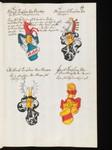

In [39]:
images[0]

As you can see, this is a small thumbnail of a manuscript image page that has four coats-of-arms. Don't worry about these thumbnails, the model can make sense of the data because most models condense large images down to a smaller space. We will lose some of the features of the data, though, since we don't have has a large of an image. I kept the files small for this notebook because it makes the process faster for in-class exercises.

Now that we have our data, now comes the fun part, vectorizing it with a multimodal model. We will use `clip` which can handle both text and images.

In [4]:
multimodal_model = SentenceTransformer('clip-ViT-B-32')

With our model loaded, we can pass our images to it, just as we would text.

In [5]:
embeddings = multimodal_model.encode(images,
                              show_progress_bar=False)

: 

For this example, we will be using Annoy again. If you remember from the last notebook, we need to know the shape of our data. Let's go ahead and print that off now.

In [19]:
embeddings.shape

AttributeError: 'Embeddings' object has no attribute 'shape'

And here is what one of those vectors looks like

In [ ]:
embeddings[0]

To create the index, we will again use AnnoyIndex.

In [ ]:
annoy_index = AnnoyIndex(512, metric='angular')

Again, we will populate that index with `add_item()`.

In [ ]:
for idx, emb in enumerate(embeddings):
    annoy_index.add_item(idx, emb)
annoy_index.build(10)

Now that we have created our index, we need to make sure that we encode our query the same way we encoded our original data.

In [ ]:
query_emb = multimodal_model.encode(["portrait"], show_progress_bar=True)

Now, let's bring this all together. Let's try and find images of a portrait. Try out other searches for a few minutes and see what you notice. I recommend trying the phrase `medieval landscape.`

In [ ]:
query_emb = multimodal_model.encode(["portrait"], show_progress_bar=True)
closest_5_idx, closest_5_dist = annoy_index.get_nns_by_vector(query_emb[0], 5,
                                        include_distances=True)
for idx, dist in zip(closest_5_idx, closest_5_dist):
    print(idx, dist)
    display(images[idx])

This is how we can build a multimodal vector database. Other frameworks, like `txtai` can also do this, but again it's important to be familiar with these steps so that you understand what's happening behind the scenes.

But the big question that remains is how we design systems that can be used in production. This is where cloud-based solutions come in. We'll learn about these with Weaviate.

# Vector Databases in Production

If you're new to cloud-based solutions and looking to implement vector databases in production, Weaviate is an excellent option to consider. As an open-source vector database, Weaviate allows you to store, search, and manage vector embeddings efficiently at scale.

## Key Features of Weaviate

1. Cloud-native architecture: Weaviate is designed to run seamlessly in cloud environments, making it ideal for scalable production deployments.

2. Multi-modal data support: It can handle various data types, including text, images, and audio, storing them as vector embeddings.

3. RESTful and GraphQL APIs: Weaviate provides intuitive APIs for easy integration with your existing applications.

4. Horizontal scalability: As your data and query needs grow, Weaviate can scale horizontally to maintain performance.

5. Real-time indexing: New data is immediately available for search and retrieval.

## Getting Started with Weaviate

To begin using Weaviate in your cloud-based solution:

1. Visit the official Weaviate website: https://weaviate.io/

2. Check out their comprehensive documentation: https://weaviate.io/developers/weaviate

3. For a quick start guide, refer to: https://weaviate.io/developers/weaviate/quickstart

4. Explore Weaviate Cloud Services for managed solutions: https://weaviate.io/pricing

As you implement Weaviate in your production environment, remember to consider factors such as data security, backup strategies, and monitoring to ensure optimal performance and reliability.

## Building a Cluster

In order to store data on the cloud, you must have a Weaviate cluster. Fortunately, Weaviate provides a free sandbox that expires after 14 days. It's a good way to prototype for free. Once you have an account, you can build a free cluster from your console dashboard. Follow the steps in this video:

![weaviate](../assets/weaviate.gif)


The steps in this video are:

1. Click "+ Create Cluster"
2. Name your cluster
3. Select a region for your server
4. Click `Create`

Once your cluster is created, you will have a server address and an API key. These can then be used to populate that cluster with data.

In [47]:
import weaviate
from weaviate.auth import AuthApiKey

# Connect to Weaviate Cloud
client = weaviate.connect_to_weaviate_cloud(
    cluster_url='',
    auth_credentials=AuthApiKey(""),
)

print(client.is_ready())

True


In [51]:
weaviate_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [67]:
vectors = client.collections.get("Vector")
vectors

In [70]:
vectors.config

In [56]:
query = weaviate_model.encode("hunger")
result = vectors.near_vector(query, "Vector")
print(result)

AttributeError: 'Collection' object has no attribute 'near_vector'

In [58]:
result = (
    client.query
    .get("Vectors")
    .with_near_vector({
        "vector": query,
        "certainty": 0.7
    })
    .with_limit(2)
    .do()
)

AttributeError: 'WeaviateClient' object has no attribute 'query'